In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
file_path = '/content/drive/My Drive/Datasets/retail_data.csv'

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
## 1. Data Loading and Preparation
def load_and_prepare_data(filepath):
    try:
        df = pd.read_csv(filepath)

        # Basic data validation
        required_columns = ['Customer_ID', 'Date', 'Amount']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Missing required columns. Needed: {required_columns}")

        # Convert and validate dates
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        if df['Date'].isnull().any():
            print("Warning: Some dates couldn't be parsed. These rows will be dropped.")
            df = df.dropna(subset=['Date'])

        # Sort by customer and date
        df = df.sort_values(['Customer_ID', 'Date'])

        return df

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [13]:
## 2. Feature Engineering
def create_features(df):
    # Aggregate daily spending per customer
    daily_spending = df.groupby(['Customer_ID', 'Date'])['Amount'].sum().reset_index()

    # Time-based features
    daily_spending['day_of_week'] = daily_spending['Date'].dt.dayofweek
    daily_spending['day_of_month'] = daily_spending['Date'].dt.day
    daily_spending['month'] = daily_spending['Date'].dt.month
    daily_spending['is_weekend'] = daily_spending['day_of_week'].isin([5, 6]).astype(int)

    # Lag features
    daily_spending['prev_day_spending'] = daily_spending.groupby('Customer_ID')['Amount'].shift(1)
    daily_spending['rolling_7day_mean'] = daily_spending.groupby('Customer_ID')['Amount'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean())

    # Drop NA values from lag features
    daily_spending = daily_spending.dropna()

    return daily_spending

In [14]:
## 3. Sequence Creation with Auto-Adjustment
def create_sequences_with_fallback(data, initial_sequence_length=7):
    def create_sequences(data, sequence_length):
        sequences = []
        targets = []

        for customer_id in data['Customer_ID'].unique():
            customer_data = data[data['Customer_ID'] == customer_id].sort_values('Date')

            if len(customer_data) <= sequence_length:
                continue

            values = customer_data[['Amount', 'day_of_week', 'day_of_month',
                                  'month', 'is_weekend', 'prev_day_spending',
                                  'rolling_7day_mean']].values

            for i in range(len(values) - sequence_length):
                sequences.append(values[i:i+sequence_length])
                targets.append(values[i+sequence_length, 0])

        return np.array(sequences), np.array(targets)


         # Try decreasing sequence lengths until we get valid sequences
    for seq_len in range(initial_sequence_length, 0, -1):
        X, y = create_sequences(data, seq_len)
        if len(X) > 0:
            print(f"Created {len(X)} sequences with length {seq_len}")
            return X, y, seq_len

    raise ValueError("Could not create sequences with any length")


In [15]:
## 4. Model Building
def build_rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


Transaction count per customer:
count    77852.000000
mean         2.346606
std          1.287026
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
dtype: float64
Created 29 sequences with length 7
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0559 - mae: 0.2029 - val_loss: 0.0160 - val_mae: 0.1143
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - loss: 0.0345 - mae: 0.1512 - val_loss: 0.0082 - val_mae: 0.0885
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0202 - mae: 0.1171 - val_loss: 0.0093 - val_mae: 0.0702
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0195 - mae: 0.1247 - val_loss: 0.0155 - val_mae: 0.0909
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0212 - mae: 0.1235 - val_loss: 0.0207 - val_mae: 0.1168
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0239 - mae: 0.1301 - val_loss: 0.0222 - val_mae: 0.1229
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0304 - mae: 0.1403 - val_loss: 0.0198 - val_mae: 0.1127


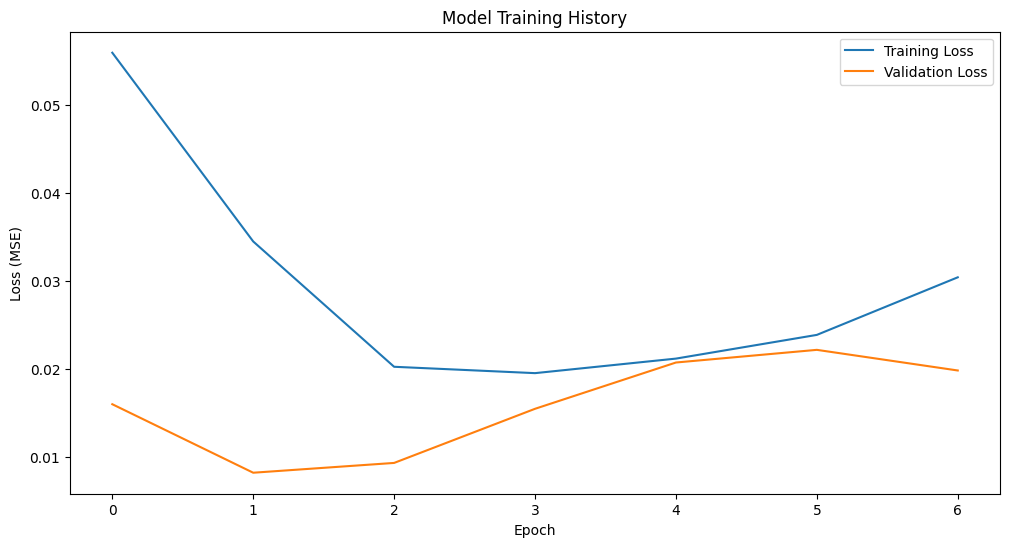

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Actual: 0.19, Predicted: 0.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Actual: 0.27, Predicted: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Actual: 0.27, Predicted: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Actual: 0.23, Predicted: 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Actual: 0.23, Predicted: 0.13


In [17]:
## 5. Main Execution Flow
def main():
    # 1. Load data

    df = load_and_prepare_data(file_path)
    if df is None:
        return

    # 2. Analyze transaction distribution
    print("\nTransaction count per customer:")
    print(df.groupby('Customer_ID').size().describe())

    # 3. Feature engineering
    daily_spending = create_features(df)

    # 4. Normalize features
    feature_columns = ['Amount', 'day_of_week', 'day_of_month',
                      'month', 'is_weekend', 'prev_day_spending',
                      'rolling_7day_mean']

    scaler = MinMaxScaler()
    daily_spending[feature_columns] = scaler.fit_transform(daily_spending[feature_columns])

    # 5. Create sequences
    try:
        X, y, seq_length = create_sequences_with_fallback(daily_spending)
    except ValueError as e:
        print(f"Error: {str(e)}")
        print("Consider aggregating data by week or using a non-time-series approach.")
        return

    # 6. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 7. Build and train model
    model = build_rnn_model((X_train.shape[1], X_train.shape[2]))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )


     # 9. Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

    # 10. Sample predictions
    sample_idx = np.random.randint(0, len(X_test), 5)
    for idx in sample_idx:
        actual = y_test[idx]
        pred = model.predict(X_test[np.newaxis, idx])[0, 0]
        print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")

if __name__ == "__main__":
    main()